In [ ]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import glob
import seaborn as sns
from keras.models import Sequential
from keras.layers import GRU, Dense, Bidirectional
from keras.utils import to_categorical
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, roc_curve, auc
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
from IPython.display import Image

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
def convert_2d(df_dup):
    data_frame = pd.DataFrame()
    for i in range(0, df_dup.shape[0]-59):
        is_anomaly = False
        mylist = []
        for j in range(i, i+60):
            mylist.append(df_dup['value'].iat[j])
            if df_dup['is_anomaly'].iat[j] == 1:
                is_anomaly = True
        if is_anomaly:
            mylist.append(1)
        else:
            mylist.append(0)
        np_Array = np.array(mylist)
        mylist = np_Array.T
        data_frame = data_frame.append(pd.Series(mylist), ignore_index=True)
    return data_frame

In [ ]:
df=pd.read_csv("/content/drive/MyDrive/ydata-labeled-time-series-anomalies-v1_0/A1Benchmark/real_1.csv")
df.head()

,timestamp,value,is_anomaly
0,1,0.000000,0
1,2,0.091758,0
2,3,0.172297,0
3,4,0.226219,0
4,5,0.176358,0


In [ ]:
path = r'/content/drive/MyDrive/ydata-labeled-time-series-anomalies-v1_0/A1Benchmark'
all_files = glob.glob(path + "/*.csv")

In [ ]:
dataset_conc = []
for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    df = df.replace(0, np.nan)
    df = df.dropna(axis=0, how='any', subset=['value'])
    df.value = preprocessing.normalize([df.value]).T
    dataset_conc.append(convert_2d(df))

frame = pd.concat(dataset_conc, axis=0, ignore_index=True)

Streaming output truncated to the last 5000 lines.
<ipython-input-3-e9b63d8afbd4>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame = data_frame.append(pd.Series(mylist), ignore_index=True)
<ipython-input-3-e9b63d8afbd4>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame = data_frame.append(pd.Series(mylist), ignore_index=True)
<ipython-input-3-e9b63d8afbd4>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame = data_frame.append(pd.Series(mylist), ignore_index=True)
<ipython-input-3-e9b63d8afbd4>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame = data_frame.append(pd.Series(mylist), ignore_index

In [ ]:
print(frame.columns)

RangeIndex(start=0, stop=61, step=1)


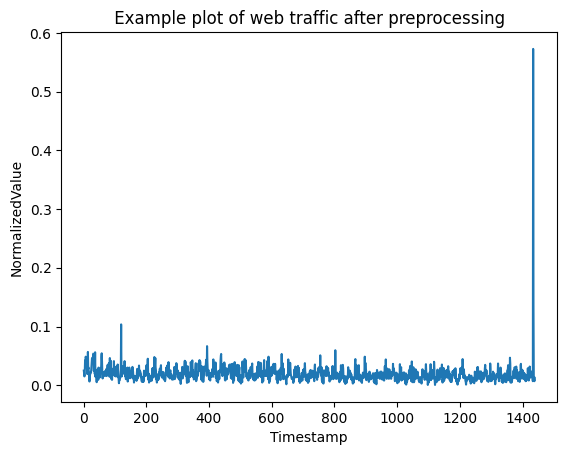

In [ ]:
import matplotlib.pyplot as plt
plt.plot(df.timestamp,df.value)
plt.xlabel("Timestamp")
plt.ylabel("NormalizedValue")
plt.title(" Example plot of web traffic after preprocessing ")
plt.show()

In [ ]:
model = Sequential()
model.add(Bidirectional(GRU(64, activation='tanh', return_sequences=True), input_shape=(60, 1)))
model.add(GRU(64, activation='tanh', return_sequences=False))
model.add(Dense(32, activation='tanh'))
model.add(Dense(2, activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

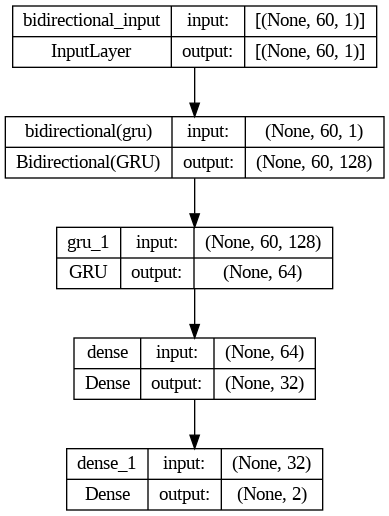

In [ ]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
y = frame.iloc[:, 60]
X = frame.iloc[:, 0:60]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
smote = SMOTE(sampling_strategy='minority', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


In [ ]:
y_train_resampled = to_categorical(y_train_resampled, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

In [ ]:
class_weights_resampled = class_weight.compute_sample_weight(class_weight='balanced', y=y_train_resampled[:, 1])

In [ ]:
history = model.fit(x=X_train_resampled, y=y_train_resampled, batch_size=256, epochs=40, verbose=2,
                    sample_weight=class_weights_resampled,
                    validation_data=(X_test, y_test))

Epoch 1/40
440/440 - 14s - loss: 0.6001 - accuracy: 0.6419 - val_loss: 0.5282 - val_accuracy: 0.8315 - 14s/epoch - 31ms/step
Epoch 2/40
440/440 - 5s - loss: 0.5613 - accuracy: 0.6681 - val_loss: 0.4984 - val_accuracy: 0.8685 - 5s/epoch - 12ms/step
Epoch 3/40
440/440 - 6s - loss: 0.5553 - accuracy: 0.6701 - val_loss: 0.4408 - val_accuracy: 0.8393 - 6s/epoch - 13ms/step
Epoch 4/40
440/440 - 5s - loss: 0.5456 - accuracy: 0.6772 - val_loss: 0.5024 - val_accuracy: 0.7879 - 5s/epoch - 12ms/step
Epoch 5/40
440/440 - 5s - loss: 0.5282 - accuracy: 0.6937 - val_loss: 0.5251 - val_accuracy: 0.6591 - 5s/epoch - 11ms/step
Epoch 6/40
440/440 - 6s - loss: 0.4965 - accuracy: 0.7132 - val_loss: 0.3817 - val_accuracy: 0.9232 - 6s/epoch - 13ms/step
Epoch 7/40
440/440 - 5s - loss: 0.4646 - accuracy: 0.7324 - val_loss: 0.4322 - val_accuracy: 0.8401 - 5s/epoch - 11ms/step
Epoch 8/40
440/440 - 5s - loss: 0.4433 - accuracy: 0.7425 - val_loss: 0.4358 - val_accuracy: 0.7727 - 5s/epoch - 12ms/step
Epoch 9/40
440

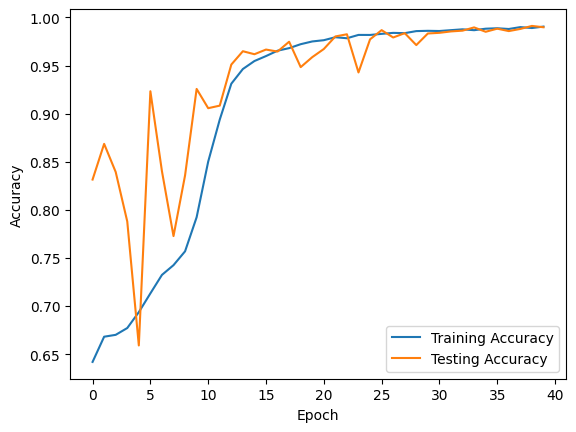

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

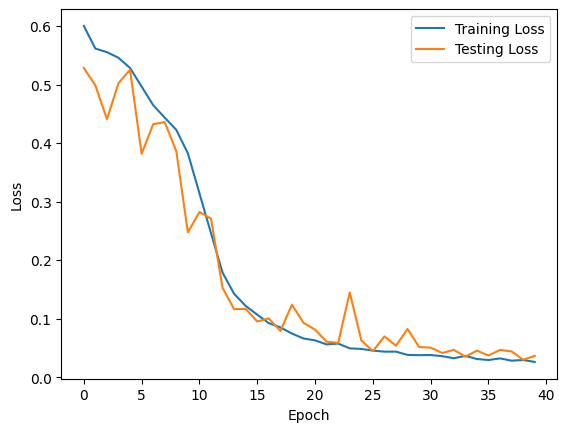

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

832/832 [==============================] - 5s 5ms/step


In [ ]:
fpr, tpr, _ = roc_curve(y_test[:, 1], y_pred)
roc_auc = auc(fpr, tpr)

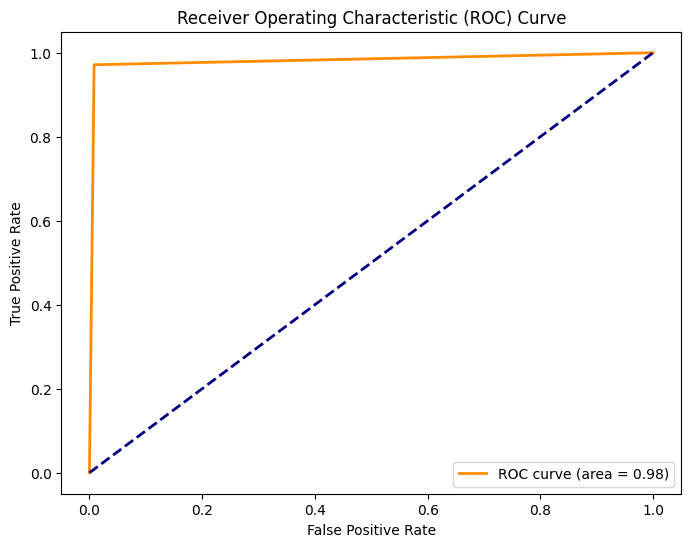

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

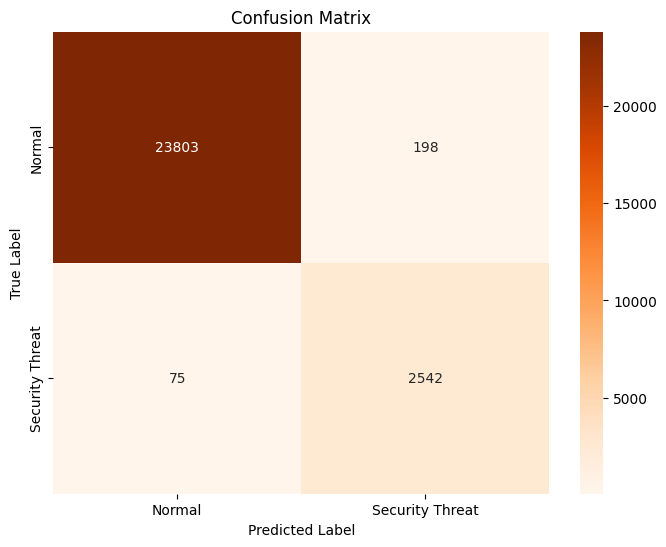

In [ ]:
confusion_matrix = confusion_matrix(y_test[:, 1], y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Oranges", xticklabels=['Normal', 'Security Threat'], yticklabels=['Normal', 'Security Threat'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
accuracy = accuracy_score(y_test[:, 1], y_pred)
precision = precision_score(y_test[:, 1], y_pred, average='binary')
recall = recall_score(y_test[:, 1], y_pred, average='binary')
f1_score = f1_score(y_test[:, 1], y_pred, average='binary')
sensitivity = recall
specificity = confusion_matrix[0, 0] / (confusion_matrix[0, 0] + confusion_matrix[0, 1])
false_positive_results = confusion_matrix[0, 1]
false_negative_results = confusion_matrix[1, 0]
kappa_coefficient = cohen_kappa_score(y_test[:, 1], y_pred)

print("Confusion Matrix")
print(confusion_matrix)
print("Accuracy ", accuracy)
print("Precision ", precision)
print("Recall ", recall)
print("F1 Score ", f1_score)
print("Specificity ", specificity)


Confusion Matrix
[[23803   198]
 [   75  2542]]
Accuracy  0.9897437824028853
Precision  0.9277372262773723
Recall  0.9713412304165074
F1 Score  0.9490386410304275
Specificity  0.9917503437356777
